Guidance for Reproducting Results:


1.   **Training Model**: Run all cells between beginning and "Main Training Cell". Set up configuration for the Main training cell: Choose number of iterations and initialisation. Set the correct path for saving check points for the model
2.   **Load Trained Model**: Run all cells from beginning and BEFORE "Main Training Cell". Next, start from "Load Saved Model and Make Predictions", modify the file path to the models desired, then run all cells after.

In [ ]:
!pip install gpytorch

In [ ]:
import pandas as pd
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv(r'/content/drive/MyDrive/STAT0035/train_set.csv', index_col = 0)
test_data = pd.read_csv(r'/content/drive/MyDrive/STAT0035/test_set.csv', index_col = 0)
data = pd.concat([train_data,test_data], axis = 0)

In [ ]:
# Get the list of all columns
all_columns = data.columns.tolist()

# Columns to exclude from scaling
exclude_columns = ['Date.time', 'turbine', 'year']

# Columns to be standardized (input features + output)
columns_to_standardize = [col for col in all_columns if col not in exclude_columns]

# Dictionary to store mean and standard deviation for each column
standardization_parameters = {}

# Standardization
for col in columns_to_standardize:
    mean = data[col].mean()
    std = data[col].std()
    standardization_parameters[col] = {'mean': mean, 'std': std}
    data[col] = (data[col] - mean) / std

In [ ]:
turbine_1 = data[data['turbine'] == 1].reset_index()
turbine_2 = data[data['turbine'] == 2].reset_index()
turbine_3 = data[data['turbine'] == 3].reset_index()
turbine_4 = data[data['turbine'] == 4].reset_index()
turbine_5 = data[data['turbine'] == 5].reset_index()
turbine_6 = data[data['turbine'] == 6].reset_index()

In [ ]:
a = 1000
train_turbine_1, test_turbine_1 = turbine_1.iloc[:3000].reset_index(drop=True), turbine_1.iloc[3000:3000+a].reset_index(drop=True)
train_turbine_2, test_turbine_2 = turbine_2.iloc[:3000].reset_index(drop=True), turbine_2.iloc[3000:3000+a].reset_index(drop=True)
train_turbine_3, test_turbine_3 = turbine_3.iloc[:3000].reset_index(drop=True), turbine_3.iloc[3000:3000+a].reset_index(drop=True)
train_turbine_4, test_turbine_4 = turbine_4.iloc[:3000].reset_index(drop=True), turbine_4.iloc[3000:3000+a].reset_index(drop=True)
train_turbine_5, test_turbine_5 = turbine_5.iloc[:3000].reset_index(drop=True), turbine_5.iloc[3000:3000+a].reset_index(drop=True)
train_turbine_6, test_turbine_6 = turbine_6.iloc[:3000].reset_index(drop=True), turbine_6.iloc[3000:3000+a].reset_index(drop=True)

In [ ]:
features =[
 'Wind.speed.me',
#  'Power.factor.cosphi.me',
#  'Front.bearing.temp.me',
#  'Stator1.temp.me',
#  'Nacelle.ambient.temp.me',
 'Nacelle.temp.me',
#  'Transformer.temp.me',
#  'Gear.oil.temp.me',
#  'Generator.bearing.rear.temp.me',
#  'Generator.bearing.front.temp.me',
#  'Motor.axis1.temp.me',
#  'CPU.temp.me',
#  'Rotor.speed.me',
#  'Gear.oil.inlet.press.me',
#  'Drive.train.acceleration.me',
 'Tower.Acceleration.x',
#  'Tower.Acceleration.y',
 ]

In [ ]:
train_x = torch.tensor(train_turbine_1[features].values)
train_y = torch.tensor(train_turbine_1['Power.me'].values)
test_x = torch.tensor(test_turbine_1[features].values)
test_y = torch.tensor(test_turbine_1['Power.me'].values)

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
# # Function to create a new model and likelihood
# def create_model_and_likelihood(train_x, train_y):
#     likelihood = gpytorch.likelihoods.GaussianLikelihood()
#     model = RBFInducingPointsGPModel(train_x, train_y, likelihood)
#     return model, likelihood

def create_model_and_likelihood(train_x, train_y):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    return model, likelihood

# Function to save the model and likelihood with an initialization identifier
def save_checkpoint(model, likelihood, iteration, init, folder='/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.3 - RBF vs MTGP/Turbine 2 (1k)'):
    os.makedirs(folder, exist_ok=True)
    torch.save(model.state_dict(), f'{folder}/model_state_init{init}_iter{iteration}.pth')
    torch.save(likelihood.state_dict(), f'{folder}/likelihood_state_init{init}_iter{iteration}.pth')

In [ ]:
# # Load saved states
# model.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Experiment Week 7/Multiple Randomisation/model_state_init3_iter1050.pth'))
# likelihood.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Experiment Week 7/Multiple Randomisation/likelihood_state_init3_iter1050.pth'))

### Main Training Cell
*  We can skip this cell if we want to load saved model
*  Parameters to we aware of:


1.   Range of initialisation (if the training breaks at 4, insert 4 in the range)
2.   Learning rate
3. Iterations until Save Checkpoints





In [ ]:
# smoke_test = ('CI' in os.environ)
# training_iter = 2 if smoke_test else 1000
# n_initializations = 10 # Number of initializations
# best_loss = float('inf')
# best_model = None
# best_likelihood = None

# # Training loop for multiple initializations
# for init in range(1,n_initializations+1):
#     model, likelihood = create_model_and_likelihood(train_x, train_y)

#     model.train()
#     likelihood.train()

#     optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
#     mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

#     with tqdm(total=training_iter, desc=f"Training Progress (Init {init})") as pbar:
#         for i in range(training_iter):
#             optimizer.zero_grad()
#             output = model(train_x)
#             loss = -mll(output, train_y)
#             loss.backward()
#             optimizer.step()

#             pbar.set_postfix(loss=loss.item())
#             pbar.update(1)

#             if (i + 1) % 100 == 0:
#                 save_checkpoint(model, likelihood, i + 1, init)  # Save checkpoint every 500 iterations for each init

#     # Compare and store the best model
#     final_loss = loss.item()
#     if final_loss < best_loss:
#         best_loss = final_loss
#         best_model = model
#         best_likelihood = likelihood

# # Save the best model and likelihood
# save_checkpoint(best_model, best_likelihood, 'final', 'best')

# print(f'Best Loss: {best_loss}')

### Load saved models and make prediction

* We need to re-run the create_model_and_likelihood again because the previous step was done in a function, thus it's local
* Need to run the previous functions for this part onwards, not the Main Training Cell

In [ ]:
model, likelihood = create_model_and_likelihood(train_x, train_y)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [ ]:
# Load saved model and likelihood
model.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.3 - RBF vs MTGP/RBF - Turbine 1/model_state_init1_iter1000.pth'))
likelihood.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.3 - RBF vs MTGP/RBF - Turbine 1/likelihood_state_init1_iter1000.pth'))

<All keys matched successfully>

In [ ]:
# Calculate loss if necessary. Note that this cell shouldn't be run twice because it will explode
# -mll(model(train_x), train_y)

### Making Prediction

Changing hyperparameters back to float64 is important for gpytorch.settings.fast_pred_var()

In [ ]:
model = model.to(torch.float64)
likelihood = likelihood.to(torch.float64)

In [ ]:
# Your existing training code here

# Make predictions on training data for confidence interval
model.eval()
likelihood.eval()

# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     train_observed_pred = likelihood(model(train_x))
#     train_lower, train_upper = train_observed_pred.confidence_region()
#     train_mean = train_observed_pred.mean.detach().numpy()
#     train_variance = train_observed_pred.variance.detach().numpy()

# Make predictions on test data
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_observed_pred = likelihood(model(test_x))
    test_lower, test_upper = test_observed_pred.confidence_region()
    test_mean = test_observed_pred.mean.detach().numpy()
    test_variance = test_observed_pred.variance.detach().numpy()

### Rescale Power.me to before standardisation

In [ ]:
# Rescale the predictions and related metrics back to original scale
def rescale_to_original(value, col):
    params = standardization_parameters[col]
    return value * params['std'] + params['mean']

# Apply rescaling for predictions and other metrics
# train_mean_original = rescale_to_original(train_mean, 'Power.me')
test_mean_original = rescale_to_original(test_mean, 'Power.me')

# train_variance_original = rescale_to_original(train_variance, 'Power.me')
test_variance_original = rescale_to_original(test_variance, 'Power.me')

# train_lower_original = rescale_to_original(train_lower.numpy(), 'Power.me')
# train_upper_original = rescale_to_original(train_upper.numpy(), 'Power.me')

test_lower_original = rescale_to_original(test_lower.numpy(), 'Power.me')
test_upper_original = rescale_to_original(test_upper.numpy(), 'Power.me')

# train_y_original = rescale_to_original(train_y.numpy(), 'Power.me')
test_y_original = rescale_to_original(test_y.numpy(), 'Power.me')

### Observing the range and distribution of re-scaled values. Good to check variance and bounds because sometimes they are too large or too small

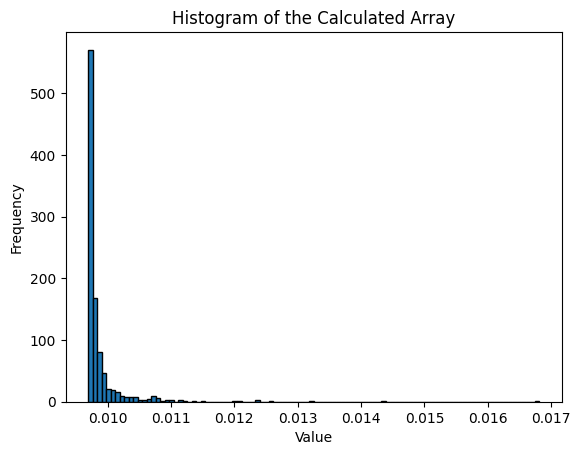

In [ ]:
plt.hist(test_variance, bins=100, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the Calculated Array')
plt.show()

### Calculate Coverage Probability

In [ ]:
def calculate_coverage_probability(y_true, lower_bound, upper_bound):

    # Count how many true values fall within the prediction intervals
    covered = ((y_true >= lower_bound) & (y_true <= upper_bound)).sum()

    # Calculate the coverage probability
    coverage_probability = covered / len(y_true)

    return coverage_probability

# Calculate coverage probability for training data
# train_coverage_probability = calculate_coverage_probability(train_y_original, train_lower_original, train_upper_original)

# Calculate coverage probability for test data
test_coverage_probability = calculate_coverage_probability(test_y_original, test_lower_original, test_upper_original)

# Output the results
# print(f"Training Data Coverage Probability: {train_coverage_probability}")
print(f"Test Data Coverage Probability: {test_coverage_probability}")

Test Data Coverage Probability: 0.939


### Calculate RMSE and Standard Error of model on training and testing data

In [ ]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Function to calculate Standard Error
def standard_error(y_true, y_pred):
    std_dev = np.std(y_true - y_pred)
    return std_dev / np.sqrt(len(y_true))

def calculate_nlpd(predicted_mean, predicted_var, actual_y):

    # Calculate the Gaussian PDF value for each test point
    pdf_values = 1 / np.sqrt(2 * np.pi * predicted_var) * np.exp(-0.5 * (actual_y - predicted_mean)**2 / predicted_var)

    # Calculate the Negative Log-Predictive Density (NLPD)
    nlpd = -np.mean(np.log(pdf_values))

    return nlpd


# Calculate RMSE and NLPD for training data
# train_rmse = rmse(train_y_original, train_mean_original)
# train_se = standard_error(train_y_original, train_mean_original)
# train_nlpd = calculate_nlpd(train_mean_original,train_variance_original, train_y_original)

# Calculate RMSE and NLPD for test data
test_rmse = rmse(test_y_original, test_mean_original)
# test_se = standard_error(test_y_original, test_mean_original)
test_nlpd = calculate_nlpd(test_mean_original, test_variance_original , test_y_original)

In [ ]:
print('Test RMSE: ', test_rmse)
print('Test NLPD: ', test_nlpd)

Test RMSE:  64.31569608724625
Test NLPD:  6.83867921845135


### Making Plots

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

# Assuming the necessary variables (test_mean_original, test_lower_original, test_upper_original, etc.) are defined as per your code

def update_plot(x_range):
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(20, 10))

    # Set x-axis range
    start, end = x_range
    ax.set_xlim(start, end)

    # Plot test data as red points
    ax.scatter(range(len(test_y_original)), test_y_original, marker='o', color='r', s=0.5, label="Test Data")

    # Plot predicted line for test data
    ax.plot(test_mean_original, 'r--', label="Test Predictive Line")

    # Plot confidence interval for test data
    ax.fill_between(range(len(test_mean_original)), test_lower_original, test_upper_original, alpha=0.2, color='red', label="Test Confidence Interval")

    # Labels and title
    ax.set_xlabel("Time (10-min Intervals)")
    ax.set_ylabel("Power")
    ax.set_title("GP Prediction with Test Data")
    ax.legend()

    # Adjust annotations as necessary to reflect only test data metrics
    ax.annotate(f'Test RMSE: [Your RMSE Value Here]', xy=(0.5, 0.8), xycoords='axes fraction')
    ax.annotate(f'Test NLPD: [Your NLPD Value Here]', xy=(0.5, 0.75), xycoords='axes fraction')

    # Show plot
    plt.show()

# Assuming test_y_original is defined as per your code
x_max = len(test_y_original)  # Update this based on your actual test dataset size
x_slider = widgets.IntRangeSlider(
    value=[0, x_max],
    min=0,
    max=x_max,
    step=1,
    description='X-axis Range:',
    continuous_update=False
)

# Show the interactive plot
interact(update_plot, x_range=x_slider)

interactive(children=(IntRangeSlider(value=(0, 1000), continuous_update=False, description='X-axis Range:', ma…

<function __main__.update_plot(x_range)>

### Plot of predicted vs observed values of Power